# CS5489 - Machine Learning
# Lecture 4a - Non-Linear Classifiers
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Nonlinear classifiers
2. Kernel trick and kernel SVM
3. Ensemble Methods - Boosting, Random Forests
4. Classification Summary

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

In [2]:
def drawplane(w, b=None, c=None, wlabel=None, poscol=None, negcol=None, lw=2, ls='k-', label=None):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # OR
    # w^T (x-c) = 0 = w^Tx - w^Tc  --> b = -w^Tc
    if c is not None:
        b = -sum(w*c)
    
    # the line
    if (abs(w[0])>abs(w[1])):   # vertical line
        x0 = array([-30,30])
        x1 = -w[0]/w[1] * x0 - b / w[1]
    else:                       # horizontal line
        x1 = array([-30,30])
        x0 = -w[1]/w[0] * x1 - b / w[0]
    
    # fill positive half-space or neg space
    if (poscol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        plt.fill(polyx, polyy, poscol, alpha=0.2)
    
    if (negcol):
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        plt.fill(polyx, polyy, negcol, alpha=0.2)
        
    # plot line
    plt.plot(x0, x1, ls, lw=lw, label=label)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)

def drawmargin(w,b,xmarg=None, label=None):
    wnorm = w / sqrt(sum(w**2))
    if xmarg is None:
        # calculate a point on the margin
        dm = 1 / sqrt(sum(w**2))
        xpt  = array([1,-w[0]/w[1]-b/w[1]])
        # then find the margin (assuming learned with SVM)
        xmarg = xpt + dm*wnorm
        xmarg2 = xpt - dm*wnorm
    else:
        # find the distance to the margin
        dm = (sum(w*xmarg)+b) / sqrt(sum(w**2))
        # move to the other side of the decision plane
        xmarg2 = xmarg - 2*dm*wnorm

    drawplane(w, c=xmarg, ls='k--', lw=1, label=label)
    drawplane(w, c=xmarg2, ls='k--', lw=1)

def plot_svm(clf, axbox, mycmap, showleg=True):
    # get line parameters
    w = clf.coef_[0]
    b = clf.intercept_[0]

    drawplane(w, b, poscol='g', negcol='r', label='boundary')
    drawmargin(w, b, label='margin')
    plt.plot(clf.support_vectors_[:,0], clf.support_vectors_[:,1],
         'ko',fillstyle='none', markeredgewidth=2, label='support vectors')
    plt.axis(axbox); plt.grid(True)
    if showleg:
        leg = plt.legend(loc='lower right', fontsize=10)
        leg.get_frame().set_facecolor('white') 

# Linear Classifiers
- So far we have only looked at _linear classifiers_
  - separate classes using a hyperplane (line, plane).
  - e.g., support vector machine, logistic regression

In [3]:
# generate random data
X,Y = datasets.make_blobs(n_samples=50, 
         centers=2, cluster_std=2, n_features=2, 
         center_box=[-5,5], random_state=4487)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

axbox = [-10,10,-10,10]

# fit SVM (kernel is the type of decision surface...more in the next lecture)
clf = svm.SVC(kernel='linear', C=inf)
clf.fit(X, Y)

maxmfig = plt.figure()
plot_svm(clf, axbox, mycmap)
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.close()

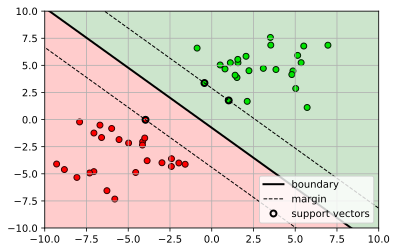

In [4]:
maxmfig

# Non-linear decision boundary
- What if the data is separable, but not linearly separable?

In [5]:
nlfig = plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
# type one - XOR
X1,Y1 = datasets.make_blobs(n_samples=100, 
         centers=array([[5,5],[-5,-5],[-5, 5], [5, -5]]), cluster_std=0.5, n_features=2, 
         random_state=4487)
Y1 = (Y1>=2)+0
plt.scatter(X1[:,0], X1[:,1], c=Y1, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

# type two - split
X2,Y2 = datasets.make_blobs(n_samples=100, 
         centers=array([[5],[-5],[0]]), cluster_std=0.5, n_features=1, 
         random_state=4487)
Y2 = (Y2>1)+0
plt.subplot(1,3,2)
plt.scatter(X2[:,0], zeros(X2.shape), c=Y2, cmap=mycmap, edgecolors='k')
plt.xlabel('$x$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])


# type three - moons
X3,Y3 = datasets.make_moons(n_samples=100,
                                             noise=0.1, random_state=4487)
plt.subplot(1,3,3)
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.close()

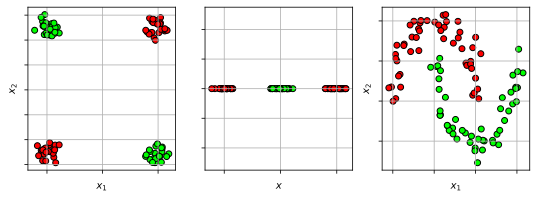

In [6]:
nlfig

# Idea - transform the input space
- map from input space $\mathbf{x} \in \mathbb{R}^d$ to a new high-dimensional space $\mathbf{z} \in \mathbb{R}^D$.
  - $\mathbf{z} = \Phi(\mathbf{x})$, where $\Phi(\mathbf{x})$ is the transformation function.
- learn the linear classifier in the new space
  - if dimension of new space is large enough ($D>d$), then the data should be linearly separable

In [7]:
nl2fig = plt.figure(figsize=(9,7))

# type one - XOR
plt.subplot2grid((5,3),(0,0), rowspan=2)
plt.scatter(X1[:,0], X1[:,1], c=Y1, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

X1t = X1[:,0]*X1[:,1]

plt.subplot2grid((5,3),(2,0))
plt.annotate("", xy=(0, -1), xytext=(0,0.8), 
             arrowprops=dict(arrowstyle='Fancy,head_width=3,tail_width=2,head_length=2'))
plt.text(0.2,0,"$\Phi(\mathbf{x}) = x_1*x_2$", fontsize=14)
plt.axis([-1, 1, -1, 1])
plt.axis('off')

plt.subplot2grid((5,3),(3,0), rowspan=2)
plt.scatter(X1t, zeros(X1t.shape), c=Y1, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1 x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.plot([0,0],[-0.5,0.5], 'k-', lw=2)

# type two - split
plt.subplot2grid((5,3),(0,1), rowspan=2)
plt.scatter(X2[:,0], zeros(X2.shape), c=Y2, cmap=mycmap, edgecolors='k')
plt.xlabel('$x$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])


plt.subplot2grid((5,3),(2,1))
plt.annotate("", xy=(0, -1), xytext=(0,0.8), 
             arrowprops=dict(arrowstyle='Fancy,head_width=3,tail_width=2,head_length=2'))
plt.text(0.2,0,"$\Phi(\mathbf{x}) = [x, x^2]$", fontsize=14)
plt.axis([-1, 1, -1, 1])
plt.axis('off')


X2t = c_[X2, X2**2]
plt.subplot2grid((5,3),(3,1), rowspan=2)
plt.scatter(X2t[:,0], X2t[:,1], c=Y2, cmap=mycmap, edgecolors='k')
plt.xlabel('$x$'); plt.ylabel('$x^2$');plt.grid(True)
plt.plot([-8,8],[10,10], 'k-', lw=2)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

# type three - moons
plt.subplot2grid((5,3),(0,2), rowspan=2)
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

plt.subplot2grid((5,3),(2,2))
plt.annotate("", xy=(0, -1), xytext=(0,0.8), 
             arrowprops=dict(arrowstyle='Fancy,head_width=3,tail_width=2,head_length=2'))
plt.text(0.2,0,"$\Phi(\mathbf{x})$", fontsize=14)
plt.axis([-1, 1, -1, 1])
plt.axis('off')

plt.subplot2grid((5,3),(3,2), rowspan=2)
plt.arrow(0,0, 10,0, lw=2, head_width=1)
plt.arrow(0,0, 0,10, lw=2, head_width=1)
plt.arrow(0,0, -7,-7, lw=2, head_width=1)

X3t,Y3t = datasets.make_blobs(n_samples=100, 
          centers=array([[-5,5],[5,-5]]), cluster_std=2, n_features=2, 
          random_state=4487)
plt.scatter(X3t[:,0], X3t[:,1], c=Y3t, cmap=mycmap, edgecolors='k')
plt.fill([5, -5, -5, 5], [10, 2, -7, 1], alpha=0.5, color='gray', ls='solid')
plt.axis([-10, 12, -10, 12])
plt.text(-10,-12,"high-dimensional features space")
plt.axis('off')

plt.close()

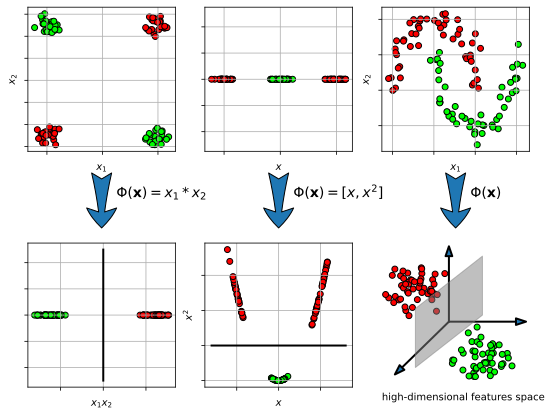

In [8]:
nl2fig

# Example
- Let's try it...
  - 2-dimensional vector inputs
    - $\mathbf{x} = \begin{bmatrix}x_1\\x_2\end{bmatrix}$
  - transformation consists of quadratic terms
    - $\Phi(\mathbf{x}) = \begin{bmatrix} x_1^2 \\ x_1x_2 \\ x_2^2 \end{bmatrix}$

In [9]:
def plot_posterior_svm(model, axbox, X, phi=None):
    # grid points
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allptsx = c_[xgrid0.ravel(), xgrid1.ravel()]

    # transform
    if phi != None:
        allpts = apply_along_axis(phi, 1, allptsx)
    else:
        allpts = allptsx
    
    # calculate the score
    score = model.decision_function(allpts).reshape(xgrid0.shape)

    cmap = ([1,0,0], [1,0.7,0.7], [0.7,1,0.7], [0,1,0])
    CS = plt.contourf(xr[0], xr[1], score, colors=cmap, 
                      levels=[-1000, -1, 0, 1, 1000], alpha=0.3)

    plt.contour(xr[0], xr[1], score, levels=[-1, 1], linewidths=1, linestyles='dashed', colors='k')
    plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', colors='k')
        
    plt.plot([-100,-100], [-100,-100], 'k-', label='boundary')
    plt.plot([-100,-100], [-100,-100], 'k--', label='margin')
    
    plt.plot(X[model.support_,0], X[model.support_,1], 
             'ko',fillstyle='none', markeredgewidth=2, label='support vectors')

    leg = plt.legend(loc='best', fontsize=7)
    leg.get_frame().set_facecolor('white')         
    plt.axis(axbox); plt.grid(True)    

In [10]:
# define the transformation function for a vector x
# (a lambda function is an anonymous function)
phi = lambda x: array([x[0]**2, x[1]**2, x[0]*x[1]])

# apply function phi to each row of data matrix X1
PX = apply_along_axis(phi, 1, X1)

# fit SVM with transformed data
clf = svm.SVC(kernel='linear', C=inf)
clf.fit(PX, Y1)

SVC(C=inf, kernel='linear')

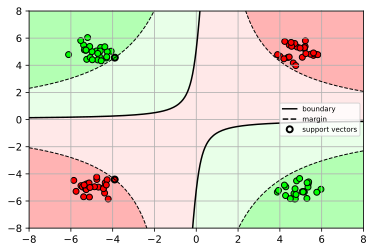

In [11]:
# make plot
axbox = [-8, 8, -8, 8]
plt.figure()
plot_posterior_svm(clf, axbox, X1, phi=phi)
plt.scatter(X1[:,0], X1[:,1], c=Y1, cmap=mycmap, edgecolors='k');

# SVM with transformed input
- Given a training set $\{\mathbf{x}_i,y_i\}_{i=1}^N$, the original SVM training is:
  $$ \mathop{\mathrm{argmin}}_{\mathbf{w},b} \frac{1}{2} \mathbf{w}^T\mathbf{w}\quad \mathrm{s.t.}~y_i (\mathbf{w}^T\mathbf{x}_i+b)\geq 1,\quad 1\leq i \leq N$$
- Apply high-dimensional transform to input $\mathbf{x}\rightarrow \Phi(\mathbf{x})$:
  $$ \mathop{\mathrm{argmin}}_{\mathbf{w},b} \frac{1}{2} \mathbf{w}^T\mathbf{w}\quad \mathrm{s.t.}~y_i(\mathbf{w}^T\Phi(\mathbf{x}_i)+b)\geq 1,\quad 1\leq i \leq N$$

- **Note:** the hyperplane $\mathbf{w}\in\mathbb{R}^D$ is now in the high-dimensional space!
  - if $D$ is very large,
    - calculating feature vector $\Phi(\mathbf{x}_i)$ could be time consuming.
    - optimization could be very inefficient in high-dimensional space.
  - To solve this problem requires some optimization theory...

# Review of Constrained Optimization
- Consider an optimization problem with inequality constraints:
$$ \min_{\mathbf{x}} f(\mathbf{x})\ \text{s.t.}\  g(\mathbf{x}) \geq 0$$
  - $f(\mathbf{x})$ is the objective function (for SVM, it's the inverse margin).
  - $g(\mathbf{x})$ is the constraint function (for SVM, it's the margin constraint).
  
<center>
<img width="500" src="imgs/fmin.png"></center>

- Use Langrange multipliers to solve this problem:
  - introduce Lagrange multiplier: $\lambda \geq 0$
  - form the Lagrangian: $L(\mathbf{x},\lambda) = f(\mathbf{x}) - \lambda g(\mathbf{x})$
  - find the stationary point $(\mathbf{x}^*, \lambda^*)$ of the Lagrangian
    - find solution of $\frac{dL}{d\mathbf{x}}=0$ and $\frac{dL}{d\lambda}=0$.
  - at the solution, the Langrange multiplier indicates the mode of the inequality constraint
    - when $\lambda^*>0$, then $g(\mathbf{x}^*)=0$ (called "active equality").
    - when $\lambda^*=0$, then $g(\mathbf{x}^*)>0$ (called "inactive").

# Duality
- We can rewrite the original (primal) problem into its dual form:
  - dual function: $q(\lambda) = \min_{\mathbf{x}} L(\mathbf{x},\lambda)$
  - dual problem: $\max_{\lambda\geq 0} q(\lambda)$
- Solve for $\lambda$, rather than original variable $\mathbf{x}$.
  - can recover the value of $\mathbf{x}$ from $\lambda$.

- If the optimization problem is convex...
  - solving the dual is equivalent to solving the **primal**
  - $\min_{\mathbf{x}, g(\mathbf{x})\geq 0} f(\mathbf{x}) = \max_{\lambda\geq 0} q(\lambda)$.
- **Note:** The SVM problem is convex, so we can obtain an equivalent dual problem.

# Lagrange multipliers & SVM
- introduce a Langrange multiplier $\alpha_i$ for each constrain
    $$ L(\mathbf{w}, \alpha) =  \frac{1}{2} \mathbf{w}^T\mathbf{w}- \sum_i \alpha_i [y_i(\mathbf{w}^T\mathbf{x}_i+b)-1] $$
- Lagrange multiplier tells us which points are on the margin:
  - If $\alpha_i=0$, then $y_i(\mathbf{w}^T\mathbf{x}_i+b)>1$ ($\mathbf{x}_i$ is beyond margin).
  - If $\alpha_i>0$, then $y_i(\mathbf{w}^T\mathbf{x}_i+b)=1$ ($\mathbf{x}_i$ is on the margin).
    - i.e., the point is a *support vector*.

# SVM Dual Problem
- The SVM problem can be rewritten as a _dual_ problem:
$$\mathop{\mathrm{argmax}}_{\alpha} \sum_i \alpha_i -\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N \alpha_i\alpha_j y_i y_j \Phi(\mathbf{x}_i)^T \Phi(\mathbf{x}_j) \\ \mathrm{s.t.} \sum_{i=1}^N \alpha_iy_i = 0, \quad \alpha_i\geq 0$$
- The new variable $\alpha_i$ corresponds to each training sample $(\mathbf{x}_i,y_i)$.
  - instead of solving for $\mathbf{w}$, we now solve for $\mathbf{\alpha}$

- Recover the hyperplane $\mathbf{w}$ using $\alpha$:
  - weighted combination of (transformed) data points.
  - $\mathbf{w} = \sum_{i=1}^N \alpha_i y_i \Phi(\mathbf{x}_i)$
- Classify a new point $\mathbf{x}_*$,  
  $$\begin{align}y_* &= \mathrm{sign}(\mathbf{w}^T\Phi(\mathbf{x}_*)+b) \\&= \mathrm{sign}(\sum_{i=1}^N \alpha_i y_i \Phi(\mathbf{x}_i)^T \Phi(\mathbf{x}_*) + b)\end{align}$$

- Interpretation of $\alpha_i$
  - $\alpha_i=0$ when the sample $\mathbf{x}_i$ is not on the margin.
  - $\alpha_i>0$ when the sample $\mathbf{x}_i$ is on the margin (or violates).
    - i.e., the sample $\mathbf{x}_i$ is a support vector.

In [12]:
alfig = plt.figure()
plot_posterior_svm(clf, axbox, X1, phi=phi)
plt.scatter(X1[:,0], X1[:,1], c=Y1, cmap=mycmap, edgecolors='k')
for i,s in enumerate(clf.support_):
    myal = clf.dual_coef_[0][i]
    myx  = X1[s]
    plt.annotate("$\\alpha=%0.3g$" % myal, xy=myx, xytext=(myx)*(0.8, 0.3),
                 arrowprops=dict(facecolor='black', shrink=0.15, width=2, headwidth=8),
                 backgroundcolor='white', 
                )
plt.text(-7,7,"$\\alpha=0$", backgroundcolor='white')
plt.text(-7,-7,"$\\alpha=0$", backgroundcolor='white')
plt.close()

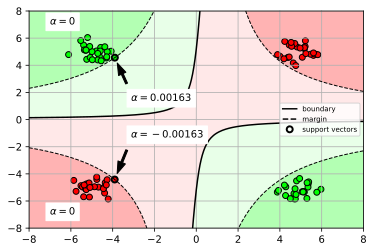

In [13]:
alfig

# Kernel function
- the SVM dual problem is completely written in terms of _inner product_ between the high-dimensional feature vectors: $\Phi(\mathbf{x}_i)^T \Phi(\mathbf{x}_j)$
- So rather than explicitly calculate the high-dimensional vector $\Phi(\mathbf{x}_i)$, 
  - we only need to calculate the inner product between two high-dim feature vectors.
- We call this a **kernel function**
  - $k(\mathbf{x}_i, \mathbf{x}_j) = \Phi(\mathbf{x}_i)^T \Phi(\mathbf{x}_j)$
  - calculating the kernel will be less expensive than explicitly calculating the high-dimensional feature vector and the inner product.

# Example: Polynomial kernel
- input vector $\mathbf{x}=\left[\begin{matrix}x_1\\\vdots\\x_d\end{matrix}\right]\in\mathbb{R}^d$
- kernel between two vectors is a $p$-th order polynomial:
  - $k(\mathbf{x},\mathbf{x}') = (\mathbf{x}^T\mathbf{x}')^p = (\sum_{i=1}^d x_i x_i')^p$

- For example, $p=2$,
  $$\begin{align}k(\mathbf{x},\mathbf{x}') &= (\mathbf{x}^T \mathbf{x}')^2 = (\sum_{i=1}^d x_i x_i')^2 \\ &= \sum_{i=1}^d \sum_{j=1}^d (x_ix_i' x_jx_j') = \Phi(\mathbf{x})^T \Phi(\mathbf{x}')\end{align}$$
  - transformed feature space is the quadratic terms of the input vector: 
    $$ \Phi(\mathbf{x}) = \left[\begin{matrix} x_1 x_1 \\ x_1 x_2 \\ \vdots  \\
    x_2 x_1 \\x_2 x_2 \\ \vdots \\
    x_d x_1 \\ \vdots \\ x_d x_d
    \end{matrix}\right]
    $$

- Comparison of number of multiplications
  - for kernel: $O(d)$
  - explicit transformation $\Phi$: $O(d^2)$

# Kernel trick
- Replacing the inner product with a kernel function in the optimization problem is called the **kernel trick**.
  - _turns a linear classification algorithm into a non-linear classification algorithm_.
  - the shape of the decision boundary is determined by the kernel.

# Kernel SVM
- Replace inner product in linear SVM with kernel function:
  $$\mathop{\mathrm{argmax}}_{\alpha} \sum_i \alpha_i -\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N \alpha_i\alpha_j y_i y_j k(\mathbf{x}_i, \mathbf{x}_j) \\ \mathrm{s.t.} \sum_{i=1}^N \alpha_iy_i = 0, \quad \alpha_i\geq 0$$
- Prediction
  - $y_* = \mathrm{sign}(\sum_{i=1}^N \alpha_i y_i k(\mathbf{x}_i, \mathbf{x}_*) + b)$

# Example: Kernel SVM with polynomial kernel
- decision surface is a "cut" of a polynomial surface
- higher polynomial-order yields more complex decision boundaries.

In [14]:
inds = (Y3==0)
X4 = X3[inds]
Y4 = Y3[inds]
tmpX,tmpY = datasets.make_blobs(n_samples=20, 
         centers=1, cluster_std=0.2, n_features=2, 
         center_box=[0,0], random_state=4487)
X4 = vstack((X4,tmpX))
Y4 = r_[Y4, tmpY+1]

In [15]:
# fit SVM (poly kernel with different degrees)
degs = [2,3,4]

clf = {}
for d in degs:
    clf[d] = svm.SVC(kernel='poly', degree=d, C=100)
    clf[d].fit(X4, Y4)

In [16]:
axbox = [-1.5, 1.5, -1.5, 1.5]

polysvmfig = plt.figure(figsize=(9,3))

for (i,d) in enumerate(degs):
    plt.subplot(1,3,i+1)
    plot_posterior_svm(clf[d], axbox, X4)
    plt.scatter(X4[:,0], X4[:,1], c=Y4, cmap=mycmap, edgecolors='k')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])    
    plt.title('polynomial deg=' + str(degs[i]))
plt.close()

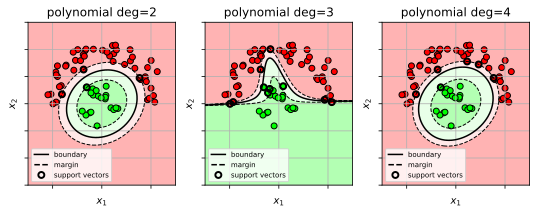

In [17]:
polysvmfig

# RBF kernel
- RBF kernel (radial basis function)
  - $k(\mathbf{x},\mathbf{x}') = e^{-\gamma\|\mathbf{x}-\mathbf{x}'\|^2}$
  - similar to a Gaussian
- gamma $\gamma>0$ is the inverse bandwidth parameter of the kernel
  - controls the smoothness of the function
  - small $\gamma$ &#8594; wider Gaussian &#8594; smooth functions
  - large $\gamma$ &#8594; thin Gaussian &#8594; wiggly function

In [18]:
rbffig = plt.figure()
x = linspace(-10,10,500)
gammas = array([0.1, 1.0, 10.0])
for g in gammas:
    kx = exp(-g*(x**2))
    plt.plot(x, kx, label="$\gamma="+str(g)+"$")
plt.xlabel("$||\mathbf{x}-\mathbf{x}'||$")
plt.ylabel("$k(\mathbf{x},\mathbf{x}')$")
plt.axis([-10, 10, 0, 1.1]); plt.grid(True)
plt.legend()
plt.close()

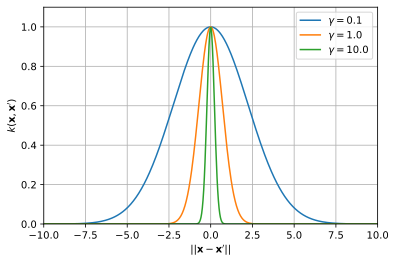

In [19]:
rbffig

# Kernel SVM with RBF kernel
- try different $\gamma$
  - each $\gamma$ yields different levels of smoothness of the decision boundary

In [20]:
# fit SVM (RBF)
gammas = [0.1, 1, 25]

clf = {}
for i in gammas:
    clf[i] = svm.SVC(kernel='rbf', gamma=i, C=1000)
    clf[i].fit(X3, Y3)

In [21]:
axbox = [-2, 3, -2, 2]

rbfsvmfig = plt.figure(figsize=(9,3))

for i,x in enumerate(gammas):
    clfx = clf[x]
    plt.subplot(1,3,i+1)

    plot_posterior_svm(clfx, axbox, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title('RBF $\gamma$=' + str(x))
plt.close()

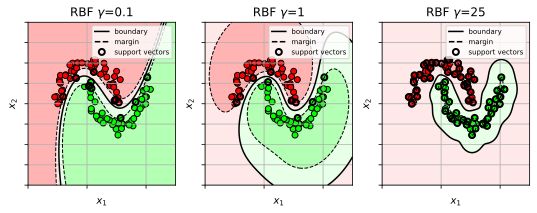

In [22]:
rbfsvmfig

# Example on Iris data
- Large $\gamma$ yields a complicated wiggly decision boundary.

In [23]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2)

print(X.shape)

(100, 2)


In [24]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(50, 2)
(50, 2)


In [25]:
# fit SVM (RBF)
gammas = [0.1, 1, 10]

clf = {}
for i in gammas:
    clf[i] = svm.SVC(kernel='rbf', gamma=i, C=100)
    clf[i].fit(trainX, trainY)

irbffig = plt.figure(figsize=(9,3))
axbox = [2.5, 7, 1.5, 4]
for i,x in enumerate(gammas):
    plt.subplot(1,3,i+1)
    plot_posterior_svm(clf[x], axbox, trainX)
    plt.scatter(trainX[:,0],trainX[:,1],c=trainY, cmap=mycmap, edgecolors='k')
    plt.xlabel('petal length'); plt.ylabel('sepal width')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title('RBF $\gamma$=' + str(x))
plt.close()

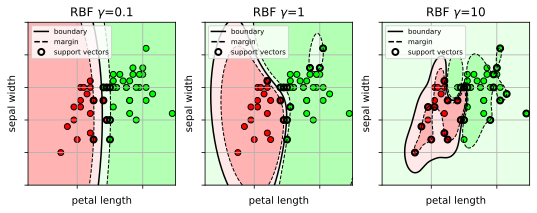

In [26]:
irbffig

# How to select the best kernel parameters?
- use cross-validation over possible kernel parameter ($\gamma$) and SVM $C$ parameter
  - if a lot of parameters, can be computationally expensive!

In [27]:
# setup the list of parameters to try
paramgrid = {'C': logspace(-2,3,20), 
             'gamma': logspace(-4,3,20) }

print(paramgrid)

# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid, cv=5,
                                    n_jobs=-1, verbose=True)

# run cross-validation (train for each split)
svmcv.fit(trainX, trainY);

print("best params:", svmcv.best_params_)

{'C': array([1.00000000e-02, 1.83298071e-02, 3.35981829e-02, 6.15848211e-02,
       1.12883789e-01, 2.06913808e-01, 3.79269019e-01, 6.95192796e-01,
       1.27427499e+00, 2.33572147e+00, 4.28133240e+00, 7.84759970e+00,
       1.43844989e+01, 2.63665090e+01, 4.83293024e+01, 8.85866790e+01,
       1.62377674e+02, 2.97635144e+02, 5.45559478e+02, 1.00000000e+03]), 'gamma': array([1.00000000e-04, 2.33572147e-04, 5.45559478e-04, 1.27427499e-03,
       2.97635144e-03, 6.95192796e-03, 1.62377674e-02, 3.79269019e-02,
       8.85866790e-02, 2.06913808e-01, 4.83293024e-01, 1.12883789e+00,
       2.63665090e+00, 6.15848211e+00, 1.43844989e+01, 3.35981829e+01,
       7.84759970e+01, 1.83298071e+02, 4.28133240e+02, 1.00000000e+03])}
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s


best params: {'C': 0.37926901907322497, 'gamma': 0.4832930238571752}


[Parallel(n_jobs=-1)]: Done 1420 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1977 out of 2000 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.4s finished


In [28]:
# show the test error for the first 25 parameter sets
N = 25
for m,p in zip(svmcv.cv_results_['mean_test_score'][0:N], svmcv.cv_results_['params'][0:N]):
    print("mean={:.4f} {}".format(m,p))

mean=0.6200 {'C': 0.01, 'gamma': 0.0001}
mean=0.6200 {'C': 0.01, 'gamma': 0.00023357214690901214}
mean=0.6200 {'C': 0.01, 'gamma': 0.000545559478116852}
mean=0.6200 {'C': 0.01, 'gamma': 0.0012742749857031334}
mean=0.6200 {'C': 0.01, 'gamma': 0.002976351441631319}
mean=0.6200 {'C': 0.01, 'gamma': 0.0069519279617756054}
mean=0.6200 {'C': 0.01, 'gamma': 0.01623776739188721}
mean=0.6200 {'C': 0.01, 'gamma': 0.0379269019073225}
mean=0.6200 {'C': 0.01, 'gamma': 0.08858667904100823}
mean=0.6200 {'C': 0.01, 'gamma': 0.2069138081114788}
mean=0.6200 {'C': 0.01, 'gamma': 0.4832930238571752}
mean=0.6200 {'C': 0.01, 'gamma': 1.1288378916846884}
mean=0.6200 {'C': 0.01, 'gamma': 2.6366508987303554}
mean=0.6200 {'C': 0.01, 'gamma': 6.1584821106602545}
mean=0.6200 {'C': 0.01, 'gamma': 14.38449888287663}
mean=0.6200 {'C': 0.01, 'gamma': 33.59818286283781}
mean=0.6200 {'C': 0.01, 'gamma': 78.47599703514607}
mean=0.6200 {'C': 0.01, 'gamma': 183.29807108324337}
mean=0.6200 {'C': 0.01, 'gamma': 428.13323987

In [29]:
def extract_grid_scores(modelcv, paramgrid):
    "extract CV scores from GridSearchCV and put into a matrix"
    # get parameters
    pkeys = list(paramgrid.keys())
    
    # initialize empty score matrix
    scoresize = [len(paramgrid[p]) for p in pkeys]
    avgscores = zeros(scoresize)

    # fill in the matrix with run for each parameter set
    for rm,rp in zip(modelcv.cv_results_['mean_test_score'], modelcv.cv_results_['params']):
        # get the index into each of the parameter lists
        myind = [where(rp[p] == paramgrid[p]) for p in pkeys]
        avgscores[tuple(myind)] = rm    # put the score

    # location of best score
    bestind = [where(modelcv.best_params_[p] == paramgrid[p]) for p in pkeys]

    return avgscores, pkeys, bestind

In [30]:
(avgscores, pnames, bestind) = extract_grid_scores(svmcv, paramgrid)
paramfig = plt.figure()
plt.imshow(avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w', markersize=12)
plt.ylabel(pnames[0] + ' index'); plt.xlabel(pnames[1] + ' index')
plt.grid(True)
plt.title('accuracy for different parameters')
plt.colorbar()
plt.axis('image');
plt.close()

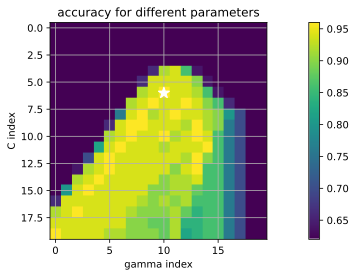

In [31]:
paramfig

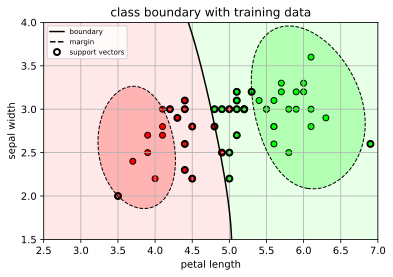

In [32]:
# show classifier with training data
plt.figure()
plot_posterior_svm(svmcv.best_estimator_, axbox, trainX)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.title('class boundary with training data');
plt.show()

In [33]:
# predict from the model
predY = svmcv.predict(testX)

# calculate accuracy
acc      = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

test accuracy = 0.88


# Custom kernel function
- we can use any kernel function, as long as it is *positive definite*:
  - 1) it can be written as an inner-product of a feature transformation: $k(\mathbf{x}_1,\mathbf{x}_2) = \langle \Phi(\mathbf{x}_1), \Phi(\mathbf{x}_2) \rangle$.
  - 2) for all possible datasets $\mathbf{X} = \{\mathbf{x}_1, \cdots \mathbf{x}_N\}$ of all possible sizes $N$, the kernel matrix $K=[k(\mathbf{x}_i,\mathbf{x}_j)]_{i,j}$ is a positive definite matrix.
    - $\mathbf{K}$ is a *positive definite matrix* iff $\mathbf{z}^T\mathbf{K}\mathbf{z} > 0, \forall \mathbf{z}$
- in sklearn, pass a callable function as the kernel parameter.

## Example: Laplacian kernel
- $k(\mathbf{x}_1,\mathbf{x}_2) = \exp(-\alpha ||\mathbf{x}_1 - \mathbf{x}_2||)$

In [34]:
from scipy import spatial

# create a custom kernel function
# Laplacian kernel: exp( -alpha*||x1-x2|| )
def mykernel(X1, X2, alpha=1.0):
    # X1,X2 are (N1 x d) and (N2 x d) matrices of N1 and N2 d-dim vectors
    # alpha is the hyperparameter
    
    # compute pairwise euclidean distance
    D = spatial.distance.cdist(X1, X2, metric='euclidean')
    
    # return the kernel matrix
    return exp(-alpha*D)

In [35]:
alphas = [0.1, 1., 10.]

clf = {}
for i in alphas:
    # make a temporary kernel function with the selected alpha value
    tmpkern = lambda X1,X2,alpha=i: mykernel(X1,X2,alpha=alpha)
    
    # create the SVM with custom kernel function
    clf[i] = svm.SVC(kernel=tmpkern, C=100)
    clf[i].fit(trainX, trainY)

In [36]:
ilapfig = plt.figure(figsize=(9,3))
axbox = [2.5, 7, 1.5, 4]
for i,x in enumerate(alphas):
    plt.subplot(1,3,i+1)
    plot_posterior_svm(clf[x], axbox, trainX)
    plt.scatter(trainX[:,0],trainX[:,1],c=trainY, cmap=mycmap, edgecolors='k')
    plt.xlabel('petal length'); plt.ylabel('sepal width')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title('Laplacian $\\alpha$=' + str(x))
plt.close()

/Users/abc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


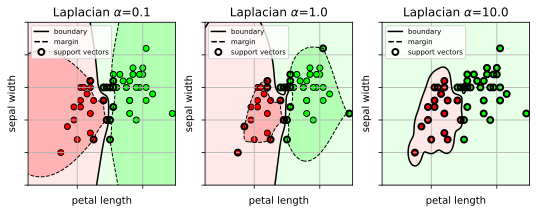

In [37]:
ilapfig

# Kernel SVM Summary
- **Kernel Classifier:**
  - Kernel function defines the shape of the non-linear decision boundary.
    - implicitly transforms input feature into high-dimensional space.
    - uses linear classifier in high-dim space.
    - the decision boundary is non-linear in the original input space.
- **Training:**
  - Maximize the margin of the training data.
    - i.e., maximize the separation between the points and the decision boundary.
  - Use cross-validation to pick the hyperparameter $C$ and the kernel hyperparameters.

- **Advantages:**
  - non-linear decision boundary for more complex classification problems
  - some intuition from the type of kernel function used.
  - kernel function can also be used to do non-vector data.
- **Disadvantages:**
  - sensitive to the kernel function used.
  - sensitive to the $C$ and kernel hyperparameters.
  - computationally expensive to do cross-validation.
  - need to calculate the kernel matrix
    - $N^2$ terms where $N$ is the size of the training set
    - for large $N$, uses a large amount of memory and computation.

#  Kernels on other types of data
- **Histograms:** $\mathbf{x} = [x_1,\cdots, x_d]$, $x_i$ is a bin value.
  - Bhattacharyya: $$k(\mathbf{x},\mathbf{x}') = \sum_{i=1}^d \sqrt{x_i x'_i}$$
  - histogram intersection: $$k(\mathbf{x},\mathbf{x}') = \sum_i \min(x_i, x_i')$$
  - $\chi^2$-RBF: $$k(\mathbf{x},\mathbf{x}') = e^{-\gamma \chi^2(\mathbf{x},\mathbf{x}')}$$
    - $\gamma$ is a inverse bandwidth parameter
    - $\chi^2$ distance: $\chi^2(\mathbf{x},\mathbf{x}') = \sum_{i=1}^d\frac{(x_i-x'_i)^2}{\tfrac{1}{2}(x_i+x'_i)}$

- **Strings**: $\mathbf{x}$ = "...." (strings can be different sizes)
  $$k(\mathbf{x},\mathbf{x}') = \sum_{s} w_s \phi_s(\mathbf{x})\phi_s(\mathbf{x}')$$
  - $\phi_s(\mathbf{x})$ is the number of times substring $s$ appears in $\mathbf{x}$.
  - $w_s>0$ is a weight.
- **Sets**: $\mathbf{X} = \{\mathbf{x}_1,\cdots, \mathbf{x}_n\}$ (sets can be different sizes)
  - intersection kernel: $$k(\mathbf{X},\mathbf{X}') = 2^{|\mathbf{X}\cap \mathbf{X}'|}$$
    - $|\mathbf{X}\cap \mathbf{X}'|$ = number of common elements.